In [1]:
import pickle

import numpy as np
from astropy.table import Table

%matplotlib inline
from matplotlib import pyplot as plt

from scipy.stats import gaussian_kde
from scipy.optimize import leastsq, least_squares

from tqdm.notebook import tqdm

In [2]:
m92_cat = Table.read('merged_catalogs/M92_redux2_all_columns.csv', format='csv')

In [3]:
def m92_chip_number(data, xvar='x', yvar='y'):
    data = data.copy()
    if 'x' in data.colnames:
        data['xx'] = data['x']
        data.remove_column('x')
    if 'y' in data.colnames:
        data['yy'] = data['y']
        data.remove_column('y')
        
    data['x'] = data[xvar]
    data['y'] = data[yvar]
    
    chipnum = np.empty(len(data['x']), dtype='U2')
    # LONG LINE ACROSS CENTER
    x=np.arange(0,10000,1)
    m1 = (5722-4126)/(479-9849)
    b1 = 5722 - m1*(479)
    y1=m1*x+b1
    # FIRST
    x2=np.arange(1900,3000)
    m2 = (7445-3445)/(2821-2114)
    b2 = 7445 - 2821*m2
    y2=m2*x2+b2
    # SECOND
    x3 = np.arange(4500,6000)
    m3 = (7064-2976)/(5664 - 4806)
    b3 = 7064 - 5664*m3
    y3=m3*x3+b3
    # THIRD
    x4=np.arange(7500,8300)
    m4 = (6561-2552)/(8222-7498)
    b4 = 6561 - 8222*m4
    y4=m4*x4+b4
    yc1 = m1*data['x'] + b1
    yc2 = m2*data['x'] + b2
    yc3 = m3*data['x'] + b3
    yc4 = m4*data['x'] + b4
    # CHIP B2
    mb2 = (data['y'] > yc1) & (data['y'] > yc2)
    chipnum[mb2] = 'b2'
    # CHIP B1
    mb1 = (data['y'] < yc1) & (data['y'] > yc2)
    chipnum[mb1] = 'b1'
    # CHIP B4
    mb4 = (data['y'] > yc1) & (data['y'] < yc2) & (data['y'] > yc3)
    chipnum[mb4] = 'b4'
    # CHIP B3
    mb3 = (data['y'] < yc1) & (data['y'] < yc2) & (data['y'] > yc3)
    chipnum[mb3] = 'b3'
    # CHIP A3
    ma3 = (data['y'] > yc1)    & (data['y'] > yc4)& (data['y'] < yc3)
    chipnum[ma3] = 'a3'
    # CHIP A4
    ma4 = (data['y'] < yc1)    & (data['y'] > yc4)& (data['y'] < yc3)
    chipnum[ma4] = 'a4'
    # CHIP A1
    ma1 = (data['y'] > yc1)    & (data['y']< yc4)
    chipnum[ma1] = 'a1'
    # CHIP A2
    ma2 = (data['y'] < yc1)    & (data['y']< yc4)
    chipnum[ma2] = 'a2'
    return chipnum

m92_cat['chipnum_090'] = m92_chip_number(m92_cat, 'F090W_xbar', 'F090W_ybar')
m92_cat['chipnum_150'] = m92_chip_number(m92_cat, 'F150W_xbar', 'F150W_ybar')
m92_cat

RA,Dec,F150W_xbar,F150W_ybar,F150W_mbar,F150W_xsig,F150W_ysig,F150W_msig,F150W_qbar,F150W_Nf,F150W_Ng,F150W_Nm,F150W_Nmin,F150W_Nstar,F150W_pki,F150W_pkj,F150W_pkp,F150W_pkn,F150W_pku,F090W_xbar,F090W_ybar,F090W_mbar,F090W_xsig,F090W_ysig,F090W_msig,F090W_qbar,F090W_Nf,F090W_Ng,F090W_Nm,F090W_Nmin,F090W_Nstar,F090W_pki,F090W_pkj,F090W_pkp,F090W_pkn,F090W_pku,chipnum_090,chipnum_150
float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64,str7,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64,str7,int64,int64,int64,int64,int64,str2,str2
259.226331832356,43.11047564341338,9472.7435,2136.2124,-6.906,0.1438,0.8495,0.044,0.9097,3,3,3,3,N000001,9472,2136,32,3,3,9472.9528,2138.0955,-6.578,1.0,1.0,9.999,0.837,1,1,1,1,N000001,9473,2136,1,1,1,a2,a2
259.2263666641808,43.11052886969171,9469.8789,2142.1985,-6.3643,0.1458,0.3181,0.5097,0.8167,3,3,3,3,N000002,9469,2141,32,3,3,9469.8789,2142.1985,0.0,9.0,9.0,9.0,0.0,0,0,0,1,N000002,9470,2142,1,1,1,a2,a2
259.2262556964723,43.110566903262416,9478.9898,2146.4832,-6.3747,0.2358,1.3443,0.1953,0.818,3,3,3,3,N000003,9478,2146,32,3,3,9478.9898,2146.4832,0.0,9.0,9.0,9.0,0.0,0,0,0,1,N000003,9479,2146,1,1,1,a2,a2
259.2272517877503,43.11066167328012,9397.1749,2157.0921,-8.7107,0.0042,0.0151,0.025,0.0912,4,4,4,3,N000004,9396,2156,32,4,3,9397.17,2157.0562,-8.376,0.0171,0.0065,0.031,0.1765,3,2,3,1,N000004,9397,2157,1,1,1,a2,a2
259.2267459801072,43.11066671902014,9438.716,2157.6864,-5.7373,0.2273,0.3456,0.2373,0.833,3,3,3,3,N000005,9438,2157,32,3,3,9438.716,2157.6864,0.0,9.0,9.0,9.0,0.0,0,0,0,1,N000005,9439,2158,1,1,1,a2,a2
259.2265213030966,43.11070092772357,9457.166,2161.5468,-9.6383,0.0073,0.0132,0.0165,0.0493,4,4,4,3,N000006,9456,2161,32,4,3,9457.158,2161.5834,-9.362,0.0126,0.0081,0.02,0.0563,3,3,3,1,N000006,9457,2162,1,1,1,a2,a2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259.3312746307161,43.16022082496399,857.2452,7732.3414,-11.2582,0.0093,0.0254,0.0057,0.0567,4,3,4,3,N189664,856,7731,32,4,3,857.229,7732.351,-11.062,0.008,0.0062,0.007,0.0517,3,3,3,1,N189664,857,7732,1,1,1,b2,b2
259.3320753565581,43.16025307369075,791.5379,7736.0093,-10.0482,0.0103,0.0196,0.0063,0.0613,4,3,4,3,N189665,791,7735,32,4,3,791.5212,7736.0222,-9.7437,0.013,0.0055,0.0067,0.069,3,3,3,1,N189665,792,7736,1,1,1,b2,b2


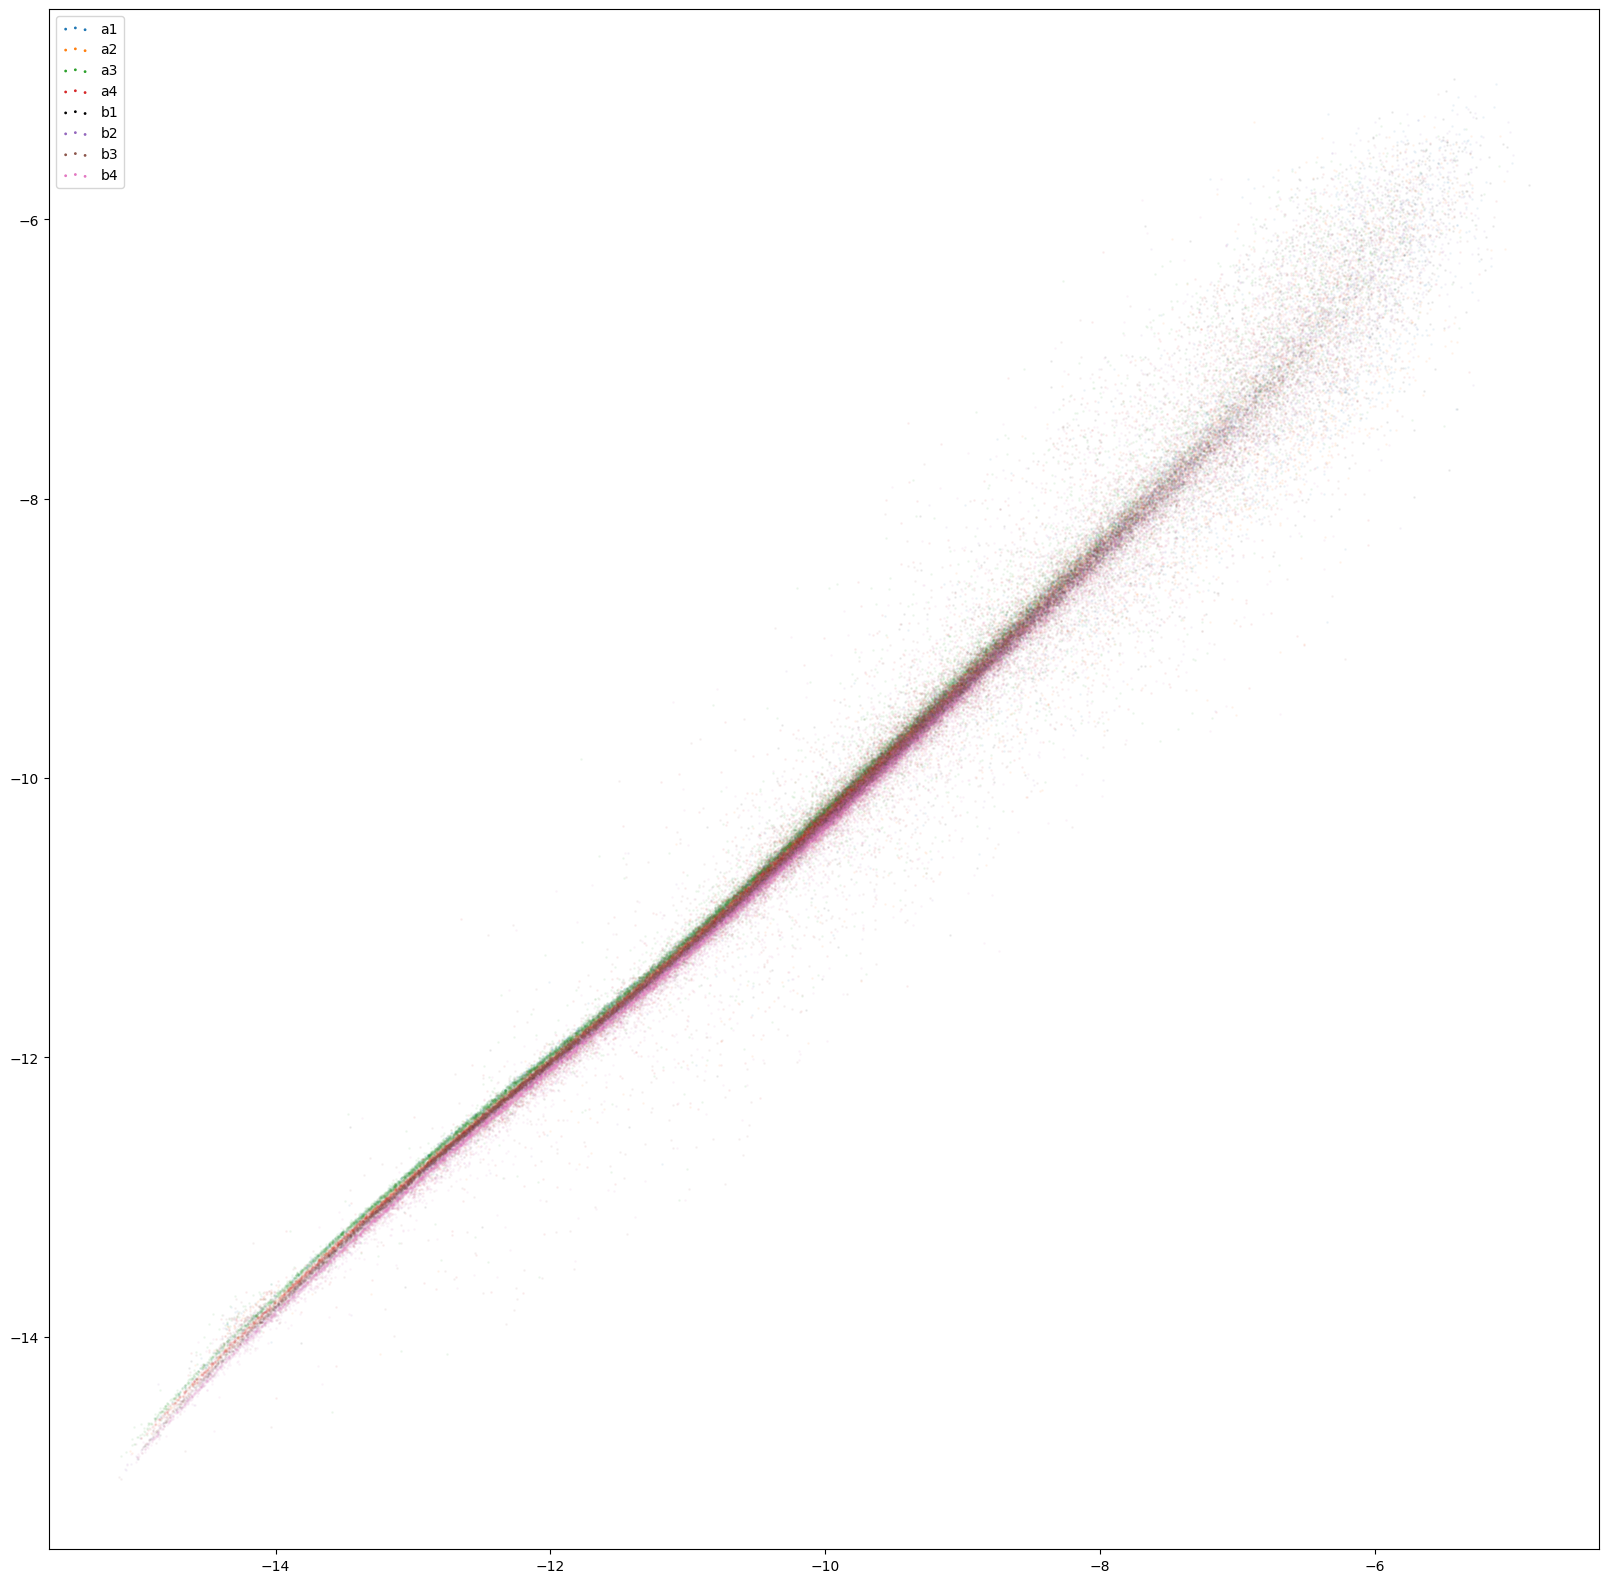

In [5]:
mag090 = m92_cat['F090W_mbar']
mag150 = m92_cat['F150W_mbar']
chipnums = m92_cat_onlygood['chipnum_090']

plt.figure(figsize=(20, 20))
for i,c in enumerate(list(np.unique(chipnums))):
    msk = (mag090!=0) & (mag150!=0) & (chipnums==c)
    
    plt.scatter(mag090[msk], mag150[msk], s=1, alpha=.05, c=None if c!='b1' else 'k', label=c)
leg = plt.legend(loc=0, scatterpoints=3)
for lh in leg.legendHandles: 
    lh.set_alpha(1)

plt.savefig('beforecorr.png')

In [6]:
bw = .02

msk = (mag090!=0) & (mag150!=0) & (chipnums=='b1')
refm1 = mag090[msk]
refm2 = mag150[msk]
kdeb1 = gaussian_kde([refm1, refm2], bw_method=bw)

msk = (mag090!=0) & (mag150!=0) & (chipnums=='a1')
kdea1 = gaussian_kde([mag090[msk], mag150[msk]], bw_method=bw)

Use b1 as the reference because it has the best calibration from the pipeline

In [7]:
def resid(dd):
    d1, d2 = dd

    k1vals = kdeb1.evaluate((refm1, refm2))
    k2vals = kdea1.evaluate((refm1 + d1, refm2 + d2))

    return (k1vals - k2vals)**2

  0%|          | 0/144 [00:00<?, ?it/s]

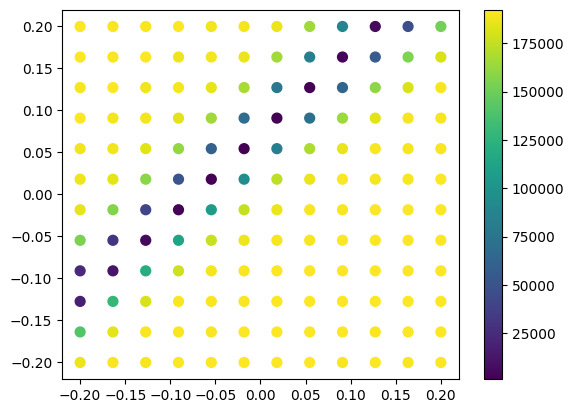

In [9]:
dxg, dyg = np.mgrid[-.2:.2:12j, -.2:.2:12j]
res = []
for xi, yi in tqdm(list(zip(dxg.ravel(), dyg.ravel()))):
    res.append(np.sum(resid((xi, yi))**2))
plt.scatter(dxg.ravel(), dyg.ravel(), c=res, s=50)
plt.colorbar()

In [44]:
%%time

res = least_squares(resid, (0,0), bounds=([-.5,-.5], [.5,.5]))

CPU times: user 55 s, sys: 9 s, total: 1min 3s
Wall time: 52.3 s


In [45]:
%%time

res2 = leastsq(resid, (0,0))

CPU times: user 49.1 s, sys: 4.52 ms, total: 49.1 s
Wall time: 49.1 s


In [47]:
res.x, res2

(array([-0.13412549, -0.11943203]), (array([-0.13410303, -0.11941171]), 1))

Now try scaling up to all chip segments, using leastsq

** Note ** Skip next three cells if you don't want to wait for the calculation but instead want to use the pickle

In [10]:
chips = list(np.unique(chipnums))
chips.remove('b1')

def resid_general(dd, kde2):
    d1, d2 = dd

    k1vals = kdeb1.evaluate((refm1, refm2))
    k2vals = kde2.evaluate((refm1 + d1, refm2 + d2))

    return (k1vals - k2vals)**2

In [11]:
kde_chips = {}
results = {}
for chip in tqdm(chips):
    msk = (mag090!=0) & (mag150!=0) & (chipnums==chip)
    kde_chips[chip] = kde_chip = gaussian_kde([mag090[msk], mag150[msk]], bw_method=bw)
    results[chip] = leastsq(resid_general, (0,0), args=kde_chip, full_output=True)

  0%|          | 0/7 [00:00<?, ?it/s]

In [12]:
with open('res2.pickle', 'wb') as f:
    pickle.dump(results, f)
for k,v in results.items():
    print(k)
    print(v[0])
    print(v[1]**0.5)

a1
[-0.07505853  0.00575782]
[[0.00194535 0.00186229]
 [0.00186229 0.00179299]]
a2
[-0.08565729 -0.03817024]
[[0.00234471 0.00223059]
 [0.00223059 0.00213228]]
a3
[-0.16517735 -0.07633433]
[[0.00211098 0.00201574]
 [0.00201574 0.00193457]]
a4
[-0.22353347 -0.17060194]
[[0.00195408 0.00187499]
 [0.00187499 0.00180996]]
b2
[-0.03994986 -0.03492343]
[[0.00270245 0.0026055 ]
 [0.0026055  0.00252147]]
b3
[-0.02652149 -0.01347079]
[[0.00234251 0.00222602]
 [0.00222602 0.00212583]]
b4
[-0.13288619 -0.15693946]
[[0.00216232 0.00204731]
 [0.00204731 0.0019506 ]]


you can run this next cell *instead* of the above two cells:

In [9]:
with open('res.pickle', 'rb') as f:
    results1 = pickle.load(f)
for k,v in results1.items():
    print(k)
    print(v[0])
    print(v[1]**0.5)

a1
[-0.13410303 -0.11941171]
[[0.00081597 0.00077705]
 [0.00077705 0.00074109]]
a2
[-0.15695605 -0.07387742]
[[0.00059054 0.00056216]
 [0.00056216 0.00053591]]
a3
[-0.23574636 -0.18296586]
[[0.00112563 0.00106896]
 [0.00106896 0.00101675]]
a4
[-0.31884427 -0.22728948]
[[0.0009342  0.00088392]
 [0.00088392 0.00083905]]
b2
[0.00239306 0.00897732]
[[0.00068304 0.00064953]
 [0.00064953 0.00061858]]
b3
[-0.09911014 -0.07965943]
[[0.00103263 0.00097824]
 [0.00097824 0.00092846]]
b4
[-0.10013029 -0.13190275]
[[0.00103785 0.00098473]
 [0.00098473 0.00093701]]


In [27]:
with open('res2.pickle', 'rb') as f:
    results = pickle.load(f)
for k,v in results.items():
    print(k)
    print(v[0])
    print(v[1]**0.5)

a1
[-0.07505853  0.00575782]
[[0.00194535 0.00186229]
 [0.00186229 0.00179299]]
a2
[-0.08565729 -0.03817024]
[[0.00234471 0.00223059]
 [0.00223059 0.00213228]]
a3
[-0.16517735 -0.07633433]
[[0.00211098 0.00201574]
 [0.00201574 0.00193457]]
a4
[-0.22353347 -0.17060194]
[[0.00195408 0.00187499]
 [0.00187499 0.00180996]]
b2
[-0.03994986 -0.03492343]
[[0.00270245 0.0026055 ]
 [0.0026055  0.00252147]]
b3
[-0.02652149 -0.01347079]
[[0.00234251 0.00222602]
 [0.00222602 0.00212583]]
b4
[-0.13288619 -0.15693946]
[[0.00216232 0.00204731]
 [0.00204731 0.0019506 ]]


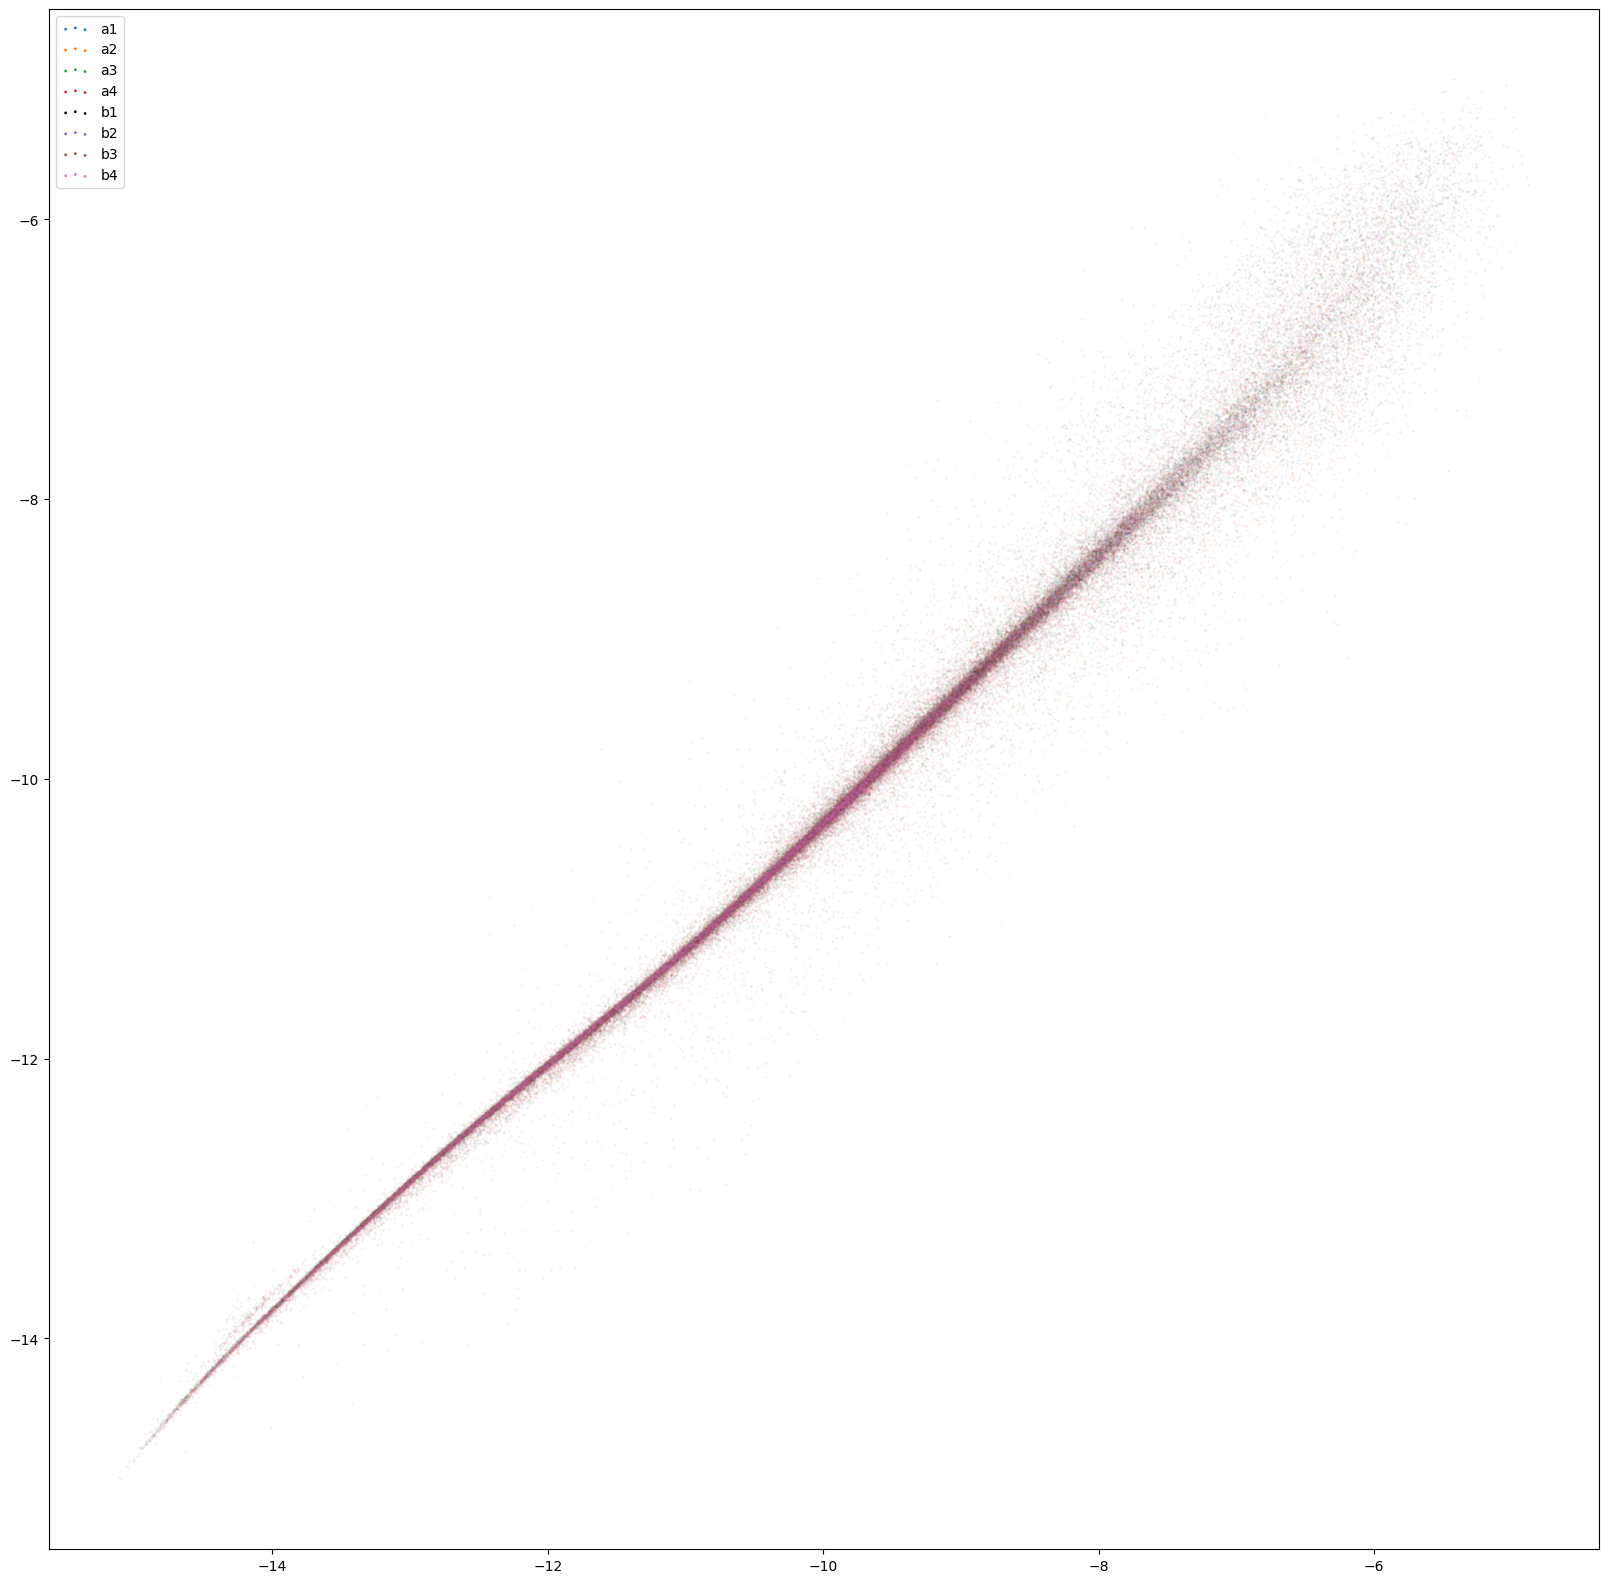

In [30]:
plt.figure(figsize=(20, 20))
for i,c in enumerate(list(np.unique(chipnums))):
    msk = (mag090!=0) & (mag150!=0) & (chipnums==c)
    if c == 'b1':
        d090 = d150 = 0
    else:
        d090 = results[c][0][0]
        d150 = results[c][0][1]
    
    plt.scatter(mag090[msk] - d090, mag150[msk] - d150, s=1, alpha=.05, c=None if c!='b1' else 'k', label=c)
leg = plt.legend(loc=0, scatterpoints=3)
for lh in leg.legendHandles: 
    lh.set_alpha(1)

plt.savefig('aftercorr.png')

(-13.0, -15.0)

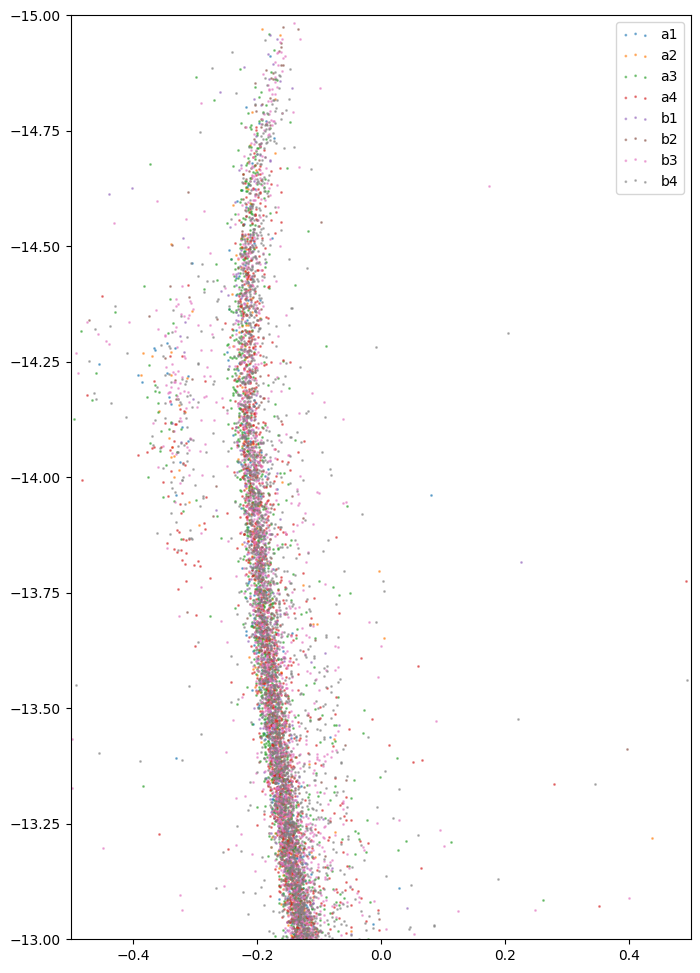

In [34]:
plt.figure(figsize=(8, 12))
for i,c in enumerate(list(np.unique(chipnums))):
    msk = (mag090!=0) & (mag150!=0) & (chipnums==c)
    if c == 'b1':
        d090 = d150 = 0
    else:
        d090 = results[c][0][0]
        d150 = results[c][0][1]
    m1 = mag090[msk] - d090
    m2 = mag150[msk] - d150
    
    plt.scatter(m1-m2, m1, s=1, alpha=.5, c=f'C{i}', label=c)

plt.legend(loc=0, scatterpoints=3)
plt.xlim(-.5, .5)
plt.ylim(-13, -15)

Now render in Jay's offset format

In [35]:
print('F090W_mbar b1 0')
print('F150W_mbar b1 0')
for chipnm, res in results.items():
    d090, d150 = res[0]
    print(f'F090W_mbar {chipnm} {d090}')
    print(f'F150W_mbar {chipnm} {d150}')

F090W_mbar b1 0
F150W_mbar b1 0
F090W_mbar a1 -0.0750585292354715
F150W_mbar a1 0.005757821643786991
F090W_mbar a2 -0.08565728673149602
F150W_mbar a2 -0.038170243888589424
F090W_mbar a3 -0.1651773506780271
F150W_mbar a3 -0.07633432741459403
F090W_mbar a4 -0.223533465741413
F150W_mbar a4 -0.1706019441278513
F090W_mbar b2 -0.039949856422705564
F150W_mbar b2 -0.034923429231095815
F090W_mbar b3 -0.026521491181185266
F150W_mbar b3 -0.013470786650655651
F090W_mbar b4 -0.13288619230902163
F150W_mbar b4 -0.15693946262290304


## Re-do the above, but with a mask for possible "bad" objects:

Note some variable names are re-used due to copy-pasting, so don't run these out-of-order with the above!

In [9]:
good_msk = (m92_cat['F090W_mbar'] < -0.1) & (m92_cat['F150W_mbar'] < -0.1) & (m92_cat['F150W_qbar'] <.25) & (m92_cat['F090W_qbar'] <.25) \
          & (m92_cat['F150W_msig'] <0.1) & (m92_cat['F090W_msig'] <0.1) & (m92_cat['F090W_Ng'] > 2) & (m92_cat['F150W_Ng'] > 2)
m92_cat_onlygood = m92_cat[good_msk]

In [12]:
mag090 = m92_cat_onlygood['F090W_mbar']
mag150 = m92_cat_onlygood['F150W_mbar']
chipnums = m92_cat_onlygood['chipnum_090']

In [13]:
bw = .02

msk = (mag090!=0) & (mag150!=0) & (chipnums=='b1')
refm1 = mag090[msk]
refm2 = mag150[msk]
kdeb1 = gaussian_kde([refm1, refm2], bw_method=bw)

msk = (mag090!=0) & (mag150!=0) & (chipnums=='a1')
kdea1 = gaussian_kde([mag090[msk], mag150[msk]], bw_method=bw)

In [14]:
chips = list(np.unique(chipnums))
chips.remove('b1')

def resid_general(dd, kde2):
    d1, d2 = dd

    k1vals = kdeb1.evaluate((refm1, refm2))
    k2vals = kde2.evaluate((refm1 + d1, refm2 + d2))

    return (k1vals - k2vals)**2

Note we are feeding in the results of the non-masked version to provide a reasonable starting point

In [30]:
kde_chips = {}
results_goodmsk = {}
for chip in tqdm(chips):
    msk = (mag090!=0) & (mag150!=0) & (chipnums==chip)
    kde_chips[chip] = kde_chip = gaussian_kde([mag090[msk], mag150[msk]], bw_method=bw)
    results_goodmsk[chip] = leastsq(resid_general, results[chip][0], args=kde_chip, full_output=True)

  0%|          | 0/7 [00:00<?, ?it/s]

In [32]:
with open('res2_goodmsk.pickle', 'wb') as f:
    pickle.dump(results_goodmsk, f)
for k,v in results_goodmsk.items():
    print(k)
    print(v[0])
    print(v[1]**0.5)

a1
[-0.04281777  0.03522018]
[[0.00012748 0.00012081]
 [0.00012081 0.0001146 ]]
a2
[-0.06840973 -0.02259675]
[[0.00012981 0.0001229 ]
 [0.0001229  0.00011647]]
a3
[-0.15740906 -0.0687923 ]
[[0.00016914 0.0001585 ]
 [0.0001585  0.00014871]]
a4
[-0.1916482  -0.14094916]
[[0.00017557 0.00016504]
 [0.00016504 0.00015527]]
b2
[-0.02068594 -0.0183157 ]
[[0.00012827 0.00012119]
 [0.00012119 0.0001146 ]]
b3
[0.00928386 0.01937204]
[[0.00021946 0.00020625]
 [0.00020625 0.00019402]]
b4
[-0.17756214 -0.19791221]
[[0.00017975 0.00016851]
 [0.00016851 0.00015811]]


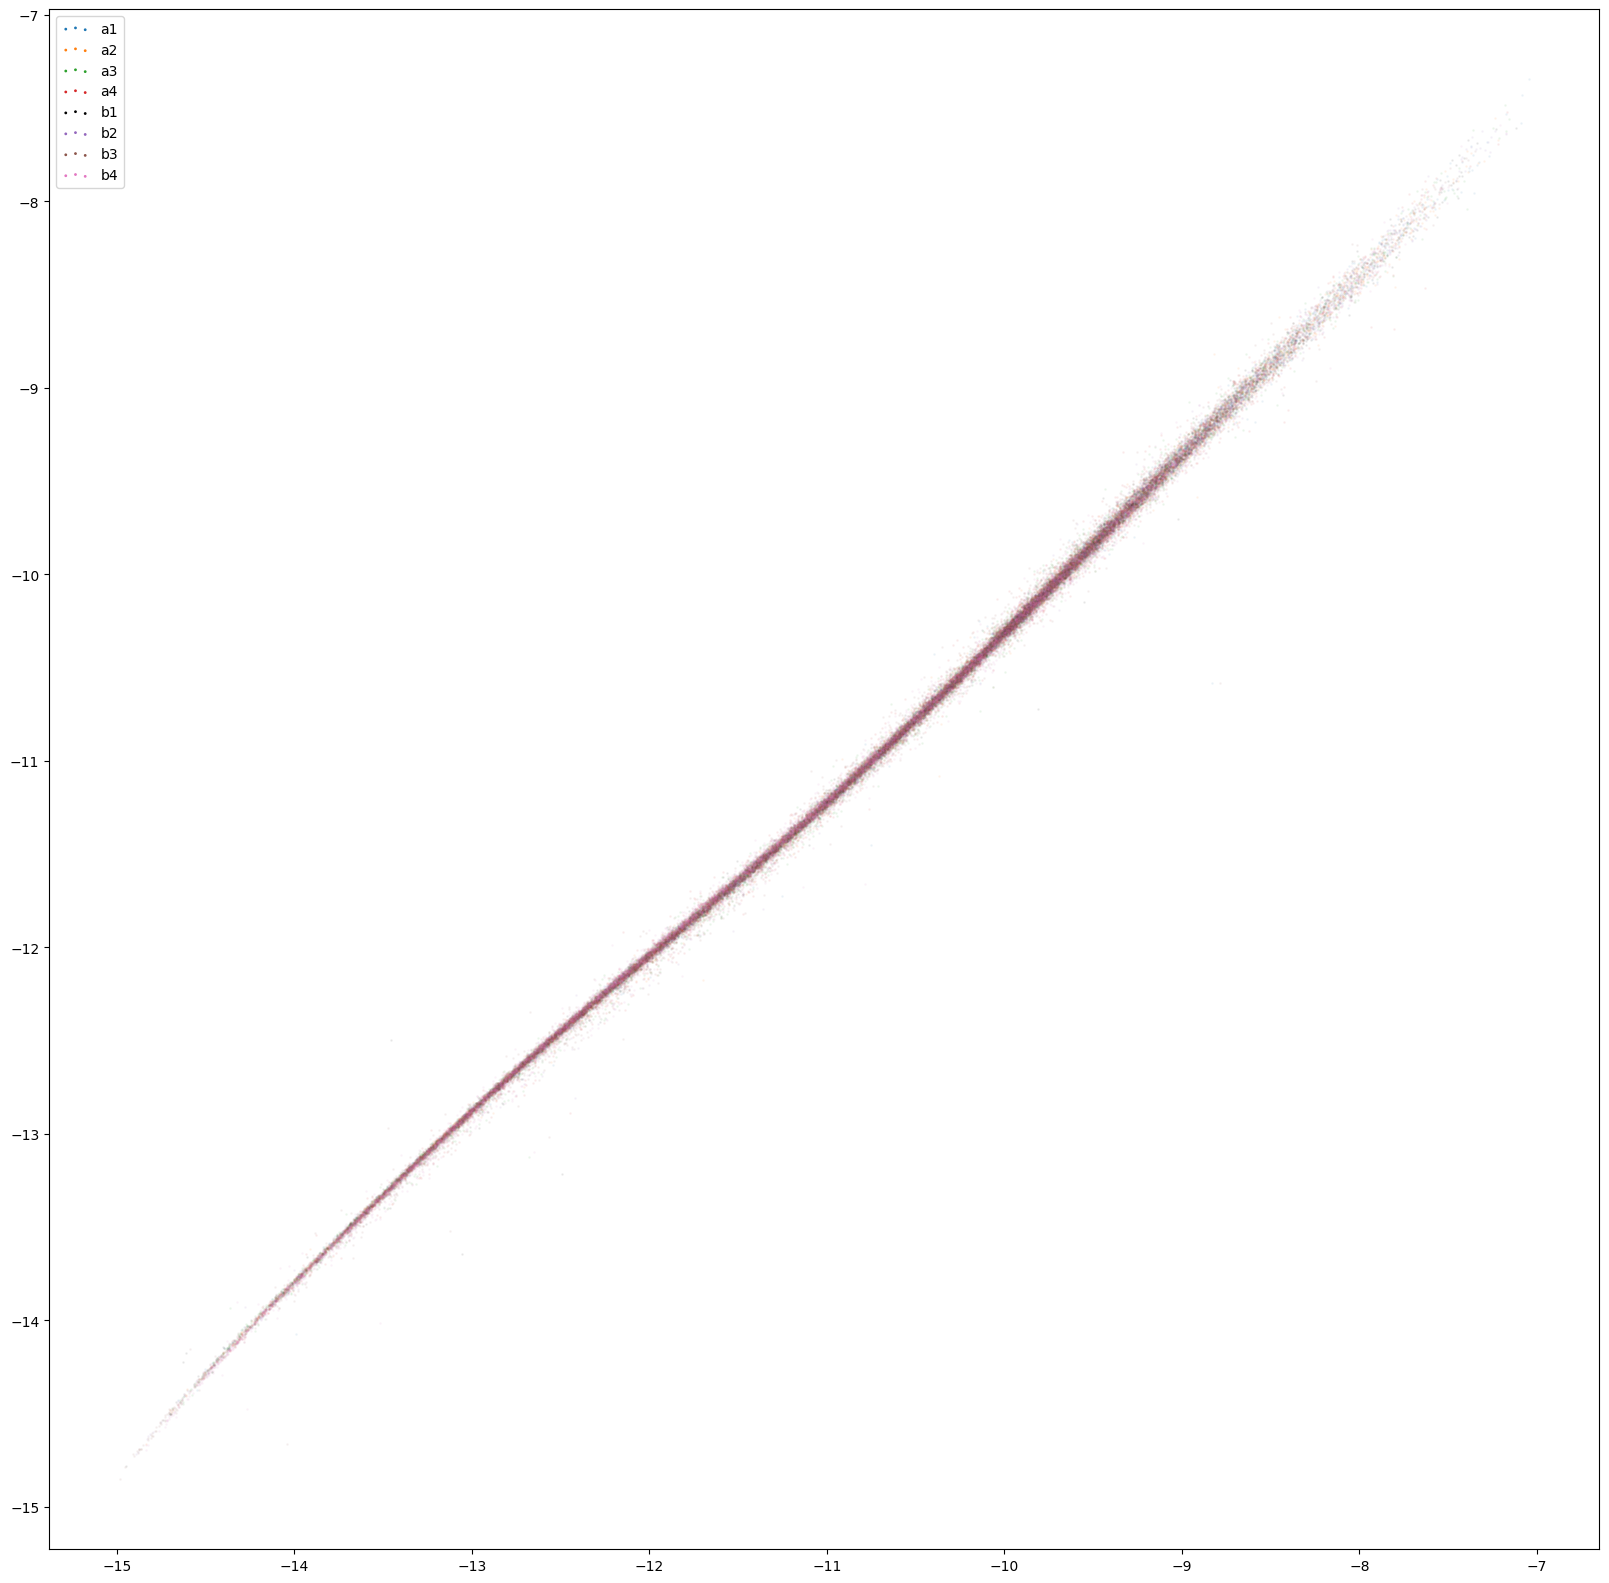

In [33]:
plt.figure(figsize=(20, 20))
for i,c in enumerate(list(np.unique(chipnums))):
    msk = (mag090!=0) & (mag150!=0) & (chipnums==c)
    if c == 'b1':
        d090 = d150 = 0
    else:
        d090 = results_goodmsk[c][0][0]
        d150 = results_goodmsk[c][0][1]
    
    plt.scatter(mag090[msk] - d090, mag150[msk] - d150, s=1, alpha=.05, c=None if c!='b1' else 'k', label=c)
leg = plt.legend(loc=0, scatterpoints=3)
for lh in leg.legendHandles: 
    lh.set_alpha(1)

plt.savefig('aftercorr_goodmsk.png')

(-13.0, -15.0)

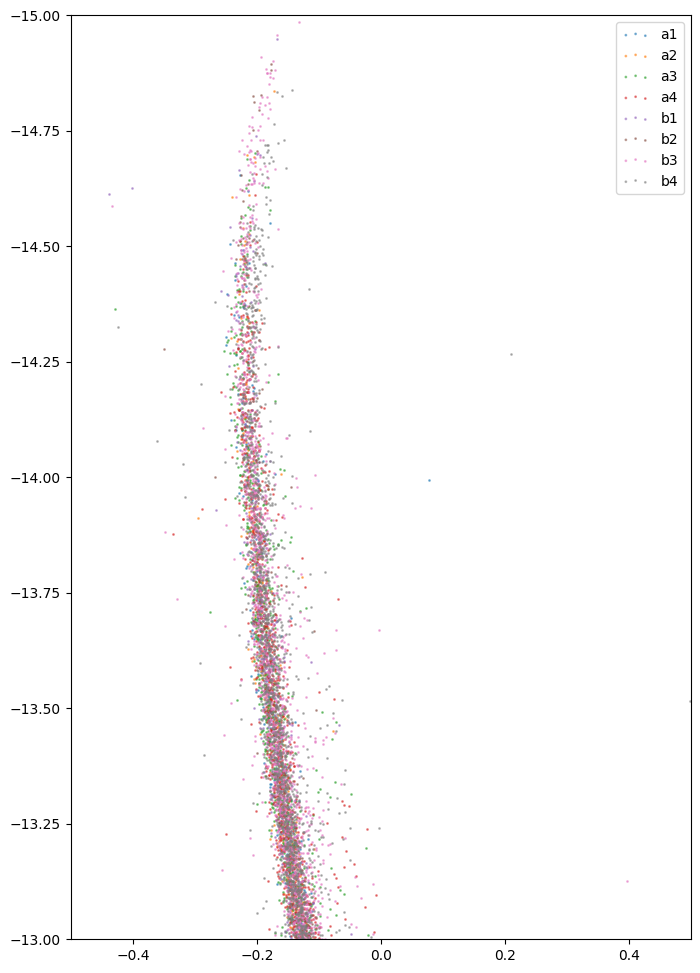

In [34]:
plt.figure(figsize=(8, 12))
for i,c in enumerate(list(np.unique(chipnums))):
    msk = (mag090!=0) & (mag150!=0) & (chipnums==c)
    if c == 'b1':
        d090 = d150 = 0
    else:
        d090 = results_goodmsk[c][0][0]
        d150 = results_goodmsk[c][0][1]
    m1 = mag090[msk] - d090
    m2 = mag150[msk] - d150
    
    plt.scatter(m1-m2, m1, s=1, alpha=.5, c=f'C{i}', label=c)

plt.legend(loc=0, scatterpoints=3)
plt.xlim(-.5, .5)
plt.ylim(-13, -15)

In [38]:
print('offsets beetween goodmsk and non-goodmsk version:')
for chipnm in results_goodmsk:
    print(chipnm)
    print(results_goodmsk[chipnm][0] - results[chipnm][0])

offsets beetween goodmsk and non-goodmsk version:
a1
[0.03224076 0.02946236]
a2
[0.01724755 0.01557349]
a3
[0.00776829 0.00754203]
a4
[0.03188526 0.02965279]
b2
[0.01926392 0.01660773]
b3
[0.03580535 0.03284283]
b4
[-0.04467595 -0.04097275]


In [35]:
print('F090W_mbar b1 0')
print('F150W_mbar b1 0')
for chipnm, res in results_goodmsk.items():
    d090, d150 = res[0]
    print(f'F090W_mbar {chipnm} {d090}')
    print(f'F150W_mbar {chipnm} {d150}')

F090W_mbar b1 0
F150W_mbar b1 0
F090W_mbar a1 -0.042817768030306395
F150W_mbar a1 0.03522018123201186
F090W_mbar a2 -0.06840973221700972
F150W_mbar a2 -0.022596752564696083
F090W_mbar a3 -0.15740905837628336
F150W_mbar a3 -0.06879229826315934
F090W_mbar a4 -0.19164820139187613
F150W_mbar a4 -0.14094915571694258
F090W_mbar b2 -0.020685935322556
F150W_mbar b2 -0.018315697153748426
F090W_mbar b3 0.009283863471738823
F150W_mbar b3 0.019372044858518393
F090W_mbar b4 -0.17756214129343736
F150W_mbar b4 -0.19791221460351366


Have a quick look at phot errors to see if there's an obvious better choice for the bw

(-0.01, 1.0)

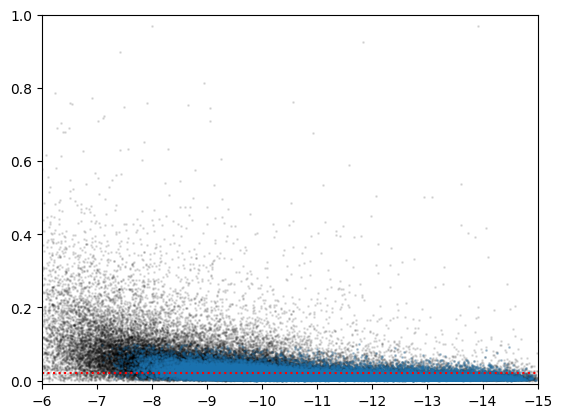

In [26]:
plt.scatter(m92_cat['F090W_mbar'], m92_cat['F090W_msig'], s=1, alpha=.1, c='k',)
plt.scatter(m92_cat_onlygood['F090W_mbar'], m92_cat_onlygood['F090W_msig'], s=1, alpha=.2)
plt.axhline(.02, ls=':', c='r')
plt.xlim(-6,-15)
plt.ylim(-0.01, 1)